# Classification of IMDB Movie Review Dataset: 
## Given the IMDB Movie Reviews, various models using RNNs and LSTMs were created and their performance was evaluated for predicting whether the given review is negative or positive.


In [1]:
# !pip install datasets torchmetrics

In [2]:
import re
import nltk
import json
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from datasets import load_dataset
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

/home2/gaurav.bhole/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# load the IMDB review dataset. I can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

## print unique labels in the dataset
# print(f"Unique labels in the dataset: {set(imdb_dataset['train']['label'])}")

In [6]:
# Create a model training loop
def train_model(model, trainloader, valloader, criterion, optimizer, epochs):
  train_losses = []
  val_losses = []
  val_accuracy = []

  for epoch in tqdm(range(epochs), desc = "Epochs"):
    ## TRAINING STEP
    model.train()
    train_loss = 0
    # train
    for input_batch, output_batch in tqdm(trainloader, total = len(trainloader), desc = "Training"):
      input_batch, output_batch = input_batch.to(device), output_batch.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward pass
      logits = model(input_batch)
      loss = criterion(logits, output_batch)

      # backward pass
      loss.backward()
      optimizer.step()

      # store train loss
      train_loss += loss.item()
    # Log metrics
      

    ## VALIDATION STEP
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    # run validation
    for input_batch, output_batch in tqdm(valloader, total = len(valloader), desc = "Validation"):
      input_batch, output_batch = input_batch.to(device), output_batch.to(device)

      # forward pass
      logits = model(input_batch)
      loss = criterion(logits, output_batch)

      # store validation loss
      val_loss += loss.item()

      # store validation accuracy
      correct += (logits.argmax(1) == output_batch).sum().item()
      total += output_batch.size(0)

    train_losses.append(train_loss / len(trainloader))
    val_losses.append(val_loss / len(valloader))
    val_accuracy.append(correct / total)

  return train_losses, val_losses, val_accuracy

In [7]:
# # Create a model testing loop
def test_model(model, testloader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  total = 0

  # run testing
  for input_batch, output_batch in tqdm(testloader, total = len(testloader), desc = "Testing"):
    input_batch, output_batch = input_batch.to(device), output_batch.to(device)

    # forward pass
    logits = model(input_batch)
    loss = criterion(logits, output_batch)

    # store test loss
    test_loss += loss.item()

    # store test accuracy
    correct += (logits.argmax(1) == output_batch).sum().item()
    total += output_batch.size(0)

  return test_loss / len(testloader), correct / total

In [8]:
def plot_confusion_matrix(model, testloader):
    model.eval()
    y_true = []
    y_pred = []
    
    for input_batch, output_batch in tqdm(testloader, total = len(testloader), desc = "Testing"):
        input_batch, output_batch = input_batch.to(device), output_batch.to(device)
    
        # forward pass
        logits = model(input_batch)
    
        # store predictions
        y_true.extend(output_batch.tolist())
        y_pred.extend(logits.argmax(1).tolist())
    
    # create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # plot heatmap
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [9]:
# Testing the model on a few sentences
def predict_sentiment(sentence, model, word2idx, clean, device):
  model.eval()

  # process the sentence
  sentence = clean(sentence)
  sentence_indices = [word2idx.get(word, 0) for word in sentence]

  # convert the sentence to tensor and add batch dimension
  sentence_tensor = torch.tensor(sentence_indices).unsqueeze(0).to(device)

  # get the model prediction
  with torch.no_grad():
    output = model(sentence_tensor)

  # convert the output to probabilities
  probabilities = nn.functional.softmax(output, dim=1).squeeze()

  if probabilities[0] > probabilities[1]:
    sentiment = "Negative"
  else:
    sentiment = "Positive"

  return sentiment, probabilities

In [10]:
def clean_basic(text):
  # Perform text preprocessing:
  # 1. Removing numbers OR replace them with "num" token
  text = re.sub(r'\d+', 'num', text)

  # 2. Convert all characters to lowercase.
  text = text.lower()

  # 3. Tokenize the sentence into words using RegexpTokenizer from NLTK.
  # I can use RegexpTokenizer from NLTK.
  text =  RegexpTokenizer(r'\w+').tokenize(text) 

  # I will experiment with stemming/lemmatization down the line
  # so I can skip that for now

  return text

# implementaion of stemming/lemmatization when doing text preprocessing using NLTK
def clean_stem_lemm(text):
    # Removing numbers OR replace them with "num" token
    text = re.sub(r'\d+', 'num', text)
    
    # Convert all characters to lowercase.
    text = text.lower()
    
    # Tokenize the sentence into words using RegexpTokenizer from NLTK.
    text = RegexpTokenizer(r'\w+').tokenize(text)
    
    # # Experimenting with stemming
    stemmer = PorterStemmer()
    text = [stemmer.stem(word) for word in text]

    # Experimenting with lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    
    return text

In [11]:
clean_basic("This IS 1 example sentence")

clean_stem_lemm("This IS 1 example sentence")

['thi', 'is', 'num', 'exampl', 'sentenc']

In [12]:
# create a word to index dictionary so that each word in the training set
# has a number associated with it. This allows to represent each sentence
# as a series of numbers. Start the index with 1 instead of 0. The number
# 0 will be used to denote padding, so that each sentence can have the
# same length.
# Keep track of the index since it will be used for representing new words
# that were not part of the training vocabulary.
# Also, make sure to not create dictionary on sentences with word count
# not within the range

def get_word2idx_basic(corpus, minlen=100, maxlen=500):
  word2idx = {}
  idx = 1
  for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx dictionary"):
    # process sentence
    sentence = clean_basic(sentence)

    # drop sentences greater than maxlen or less than minlen
    if minlen <= len(sentence) <= maxlen:
      for word in sentence:
        # for each word in sentence, check for entry in word2idx
        if word not in word2idx:
          word2idx[word] = idx
          idx += 1

  return idx, word2idx

# idxs_basic, word2idx_basic = get_word2idx_basic(imdb_dataset['train']['text'])

# # save the word2idx_basic dictionary
# with open("word2idx_basic.json", "w") as f:
#   json.dump(word2idx_basic, f)

def word2idx_stem_lemm(corpus, minlen=100, maxlen=500):
  word2idx = {}
  idx = 1
  for sentence in tqdm(corpus, total=len(corpus), desc="Creating stemmatized and lemmatized word2idx dictionary"):
    # process sentence
    sentence = clean_stem_lemm(sentence)

    # drop sentences greater than maxlen or less than minlen
    if minlen <= len(sentence) <= maxlen:
      for word in sentence:
        # for each word in sentence, check for entry in word2idx
        if word not in word2idx:
          word2idx[word] = idx
          idx += 1

  return idx, word2idx

# idxs_stem_lemm, word2idxstem_lemm = word2idx_stem_lemm(imdb_dataset['train']['text'])

# # save the word2idx_stem_lemm dictionary
# with open("word2idx_stem_lemm.json", "w") as f:
#   json.dump(word2idxstem_lemm, f)

In [13]:
# Build a Dataset object to store each sentence as a tensor of numbers
# along with the label. Make sure to add padding so that the tensor
# for each sentence is of the same length. This will allow us to train
# the model in batches.

# take the dictionary from the saved file
with open("word2idx_basic.json", "r") as f:
  word2idx_basic = json.load(f)

class IMDBDataset(Dataset):
  def __init__(self, dataset, split : str, minlen : int = 100, maxlen : int = 500, clean = clean_basic, word2idx = word2idx_basic):
    self.count = 0 # total sentences I finally pick

    # count total number of lines
    corpus = dataset[split]['text']
    length = len(dataset[split])

    input_data = []
    target_data = []

    for idx, sentence in tqdm(enumerate(corpus), total=length, desc=f"Transforming input text [{split}]"):
      # process sentence
      sentence = clean(sentence)

      # drop sentences greater than maxlen or less than minlen
      if minlen <= len(sentence) <= maxlen:
        # replace words with their index
        sentence_indices = [word2idx.get(word, 0) for word in sentence]
        input_data.append(torch.tensor(sentence_indices))
        target_data.append(dataset[split][idx]['label'])
        self.count += 1

    # pad the sentences upto maxlen
    self.inputs = pad_sequence(input_data, batch_first = True)
    self.targets = torch.tensor(target_data)

  def __len__(self) -> int:
    return self.count

  def __getitem__(self, index : int):
    return self.inputs[index], self.targets[index]

In [14]:
# take the dictionary from the saved file
with open("word2idx_basic.json", "r") as f:
  word2idx_basic = json.load(f)

# create the train dataset using the word2idx dictionary built using the train set
train_dataset_basic = IMDBDataset(imdb_dataset, 'train', clean=clean_basic, word2idx=word2idx_basic)

# Split the train set into train and validation in 80-20 split. Use the labels
# to ensure that the ratio of the samples from each label is maintained in both
train_ds_basic, val_ds_basic = train_test_split(train_dataset_basic, test_size=0.2, random_state=SEED)

# create the test dataset using the word2idx dictionary 
test_ds_basic = IMDBDataset(imdb_dataset, 'test', clean=clean_basic, word2idx=word2idx_basic)

# take the dictionary from the saved fileIMDB
with open("word2idx_stem_lemm.json", "r") as f:
    word2idxstem_lemm = json.load(f)

# create the train dataset using the word2idx dictionary built using the train set
train_dataset_stem_lemm = IMDBDataset(imdb_dataset, 'train', clean = clean_stem_lemm, word2idx = word2idxstem_lemm)

# split the train dataset into train and validation in 80-20 split
train_ds_stem_lemm, val_ds_stem_lemm = train_test_split(train_dataset_stem_lemm, test_size=0.2, random_state=SEED)

# create the test dataset using the word2idx dictionary
test_ds_stem_lemm = IMDBDataset(imdb_dataset, 'test', clean = clean_stem_lemm, word2idx = word2idxstem_lemm)

Transforming input text [test]: 100%|██████████| 25000/25000 [01:22<00:00, 304.33it/s]


In [15]:
# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader_basic = DataLoader(train_ds_basic, **params)
val_dataloader_basic = DataLoader(val_ds_basic, **params)
test_dataloader_basic = DataLoader(test_ds_basic, **params)

train_dataloader_stem_lemm = DataLoader(train_ds_stem_lemm, **params)
val_dataloader_stem_lemm = DataLoader(val_ds_stem_lemm, **params)
test_dataloader_stem_lemm = DataLoader(test_ds_stem_lemm, **params)

In [16]:
# create a model
class RNNModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, output_dim):
    super(RNNModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_dim)

  def forward(self, x):
    embedded = self.embedding(x)
    output, _ = self.rnn(embedded)
    output = self.fc(output[:, -1, :])
    return output

In [17]:
# Hyperparameters
vocab_size_basic = len(word2idx_basic) + 1 # add 1 for padding
num_classes = 2     # positive and negative (binary classification)
hidden_size = 256
embedding_dim = 100
learning_rate = 1e-3
epochs = 10

# create the model
model = RNNModel(vocab_size_basic, embedding_dim, hidden_size, num_classes).to(device)

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(model)

RNNModel(
  (embedding): Embedding(63749, 100)
  (rnn): RNN(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [18]:
# train the model
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader_basic, val_dataloader_basic, criterion, optimizer, epochs)
# save the model
torch.save(model.state_dict(), "rnn_base_model.pth")

Epochs: 100%|██████████| 10/10 [00:46<00:00,  4.69s/it]


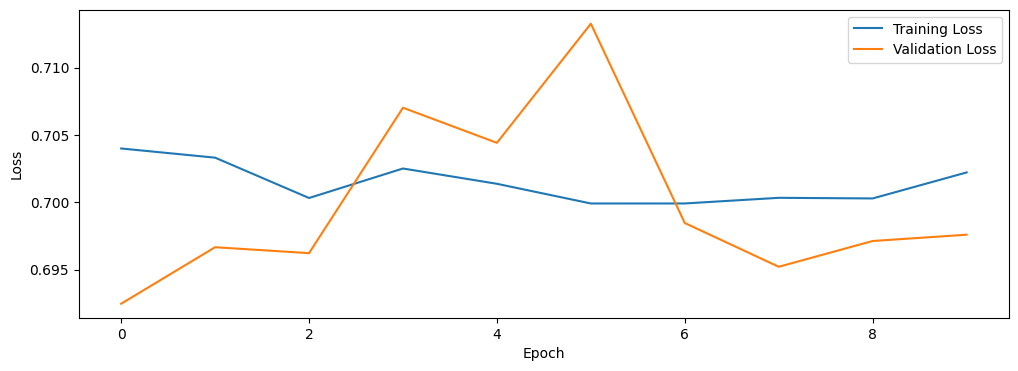

In [19]:
# plot training and validation losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

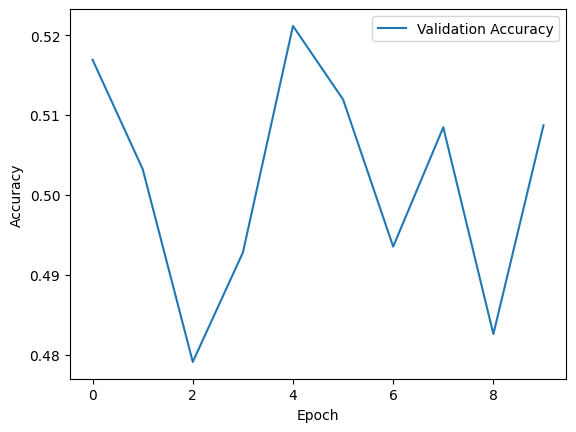

In [20]:
# plot validation accuracy
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing: 100%|██████████| 628/628 [00:02<00:00, 263.99it/s]


Test Accuracy: 0.5096


Testing: 100%|██████████| 628/628 [00:02<00:00, 264.28it/s]


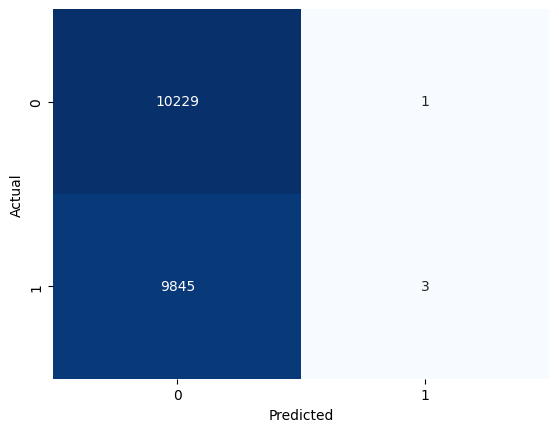

In [21]:
# load the model
model = RNNModel(vocab_size_basic, embedding_dim, hidden_size, num_classes).to(device)
model.load_state_dict(torch.load("rnn_base_model.pth"))

# find the classification accuracy on test set
test_loss, test_accuracy = test_model(model, test_dataloader_basic, criterion)
print(f"Test Accuracy: {test_accuracy:.4f}")
plot_confusion_matrix(model, test_dataloader_basic)

In [22]:
# positive review
sentence = "This movie is awesome! I really like it!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model, word2idxstem_lemm, clean_stem_lemm, device)
print(f"Sentiment: {sentiment}")

# negative review
sentence = "This movie is terrible! I really hate it!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model, word2idxstem_lemm, clean_stem_lemm, device)
print(f"Sentiment: {sentiment}")

Sentence: This movie is awesome! I really like it!
Sentiment: Negative
Sentence: This movie is terrible! I really hate it!
Sentiment: Negative


#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do I observe in accuracy ?

In [62]:
# Hyperparameters
vocab_size_stem_lemm = len(word2idxstem_lemm) + 1 # add 1 for padding
num_classes = 2     # positive and negative (binary classification)
hidden_size = 256
embedding_dim = 100
learning_rate = 1e-3
epochs = 10

# create the model
model_stem_lemm = RNNModel(vocab_size_stem_lemm, embedding_dim, hidden_size, num_classes).to(device)

# create optimizer
optimizer_stem_lemm = optim.Adam(model_stem_lemm.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(model_stem_lemm)

RNNModel(
  (embedding): Embedding(43411, 100)
  (rnn): RNN(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [64]:
# train the model
train_losses_stem_lemm, val_losses_stem_lemm, val_accuracy_stem_lemm = train_model(model_stem_lemm, train_dataloader_stem_lemm, val_dataloader_stem_lemm, criterion, optimizer_stem_lemm, epochs)

# save the model
torch.save(model_stem_lemm.state_dict(), "rnn_stem_lemm_model.pth")

Epochs: 100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


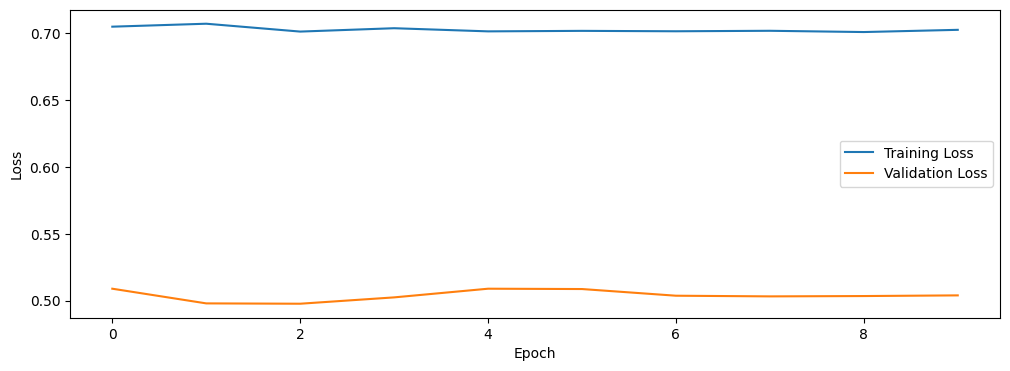

In [65]:
# plot training and validation losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses_stem_lemm, label='Training Loss')
plt.plot(val_accuracy_stem_lemm, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

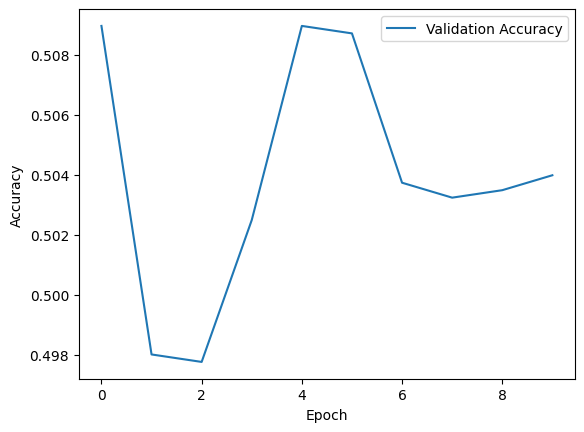

In [66]:
# plot validation accuracy
plt.plot(val_accuracy_stem_lemm, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing:   0%|          | 0/628 [00:00<?, ?it/s]

Testing: 100%|██████████| 628/628 [00:02<00:00, 252.22it/s]


Test Accuracy: 0.5001


Testing: 100%|██████████| 628/628 [00:02<00:00, 270.73it/s]


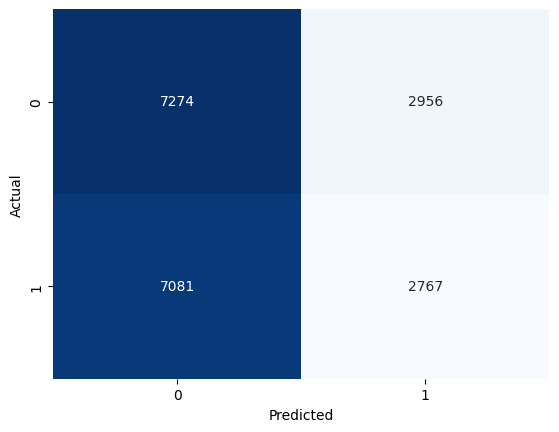

In [67]:
# load the model
model_stem_lemm = RNNModel(vocab_size_stem_lemm, embedding_dim, hidden_size, num_classes).to(device)
model_stem_lemm.load_state_dict(torch.load("rnn_stem_lemm_model.pth"))

# find the classification accuracy on test set
test_loss, test_accuracy = test_model(model_stem_lemm, test_dataloader_stem_lemm, criterion)
print(f"Test Accuracy: {test_accuracy:.4f}")
plot_confusion_matrix(model_stem_lemm, test_dataloader_stem_lemm)

In [68]:
# positive review
sentence = "This movie is excellent! I really like it because it is so interesting!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model_stem_lemm, word2idxstem_lemm, clean_stem_lemm, device)
print(f"Review: {sentiment}")

# negative review
sentence = "This movie is bad! I really hate it because it is so boring!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model_stem_lemm, word2idxstem_lemm, clean_stem_lemm, device)
print(f"Review: {sentiment}")

Sentence: This movie is excellent! I really like it because it is so interesting!
Review: Positive
Sentence: This movie is bad! I really hate it because it is so boring!
Review: Positive


#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do I observe ?

In [30]:
class RNNModelNew(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes, output_mode='last'):
        super(RNNModelNew, self).__init__()
        self.output_mode = output_mode  # 'last' for the last output, 'mean' for the mean of all outputs
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
  
    def forward(self, X):
        X = self.embedding(X)
        out, _ = self.rnn(X)

        if self.output_mode == 'last':
            out = out[:, -1, :]  # Takes the last output
        elif self.output_mode == 'mean':
            out = torch.mean(out, dim=1)  # Takes the mean of all outputs

        out = self.fc(out)
        return out

In [31]:
# Hyperparameters
vocab_size_basic = len(word2idx_basic) + 1 # add 1 for padding
num_classes = 2     # positive and negative (binary classification)
hidden_size = 256
embedding_dim = 100
learning_rate = 1e-3
epochs = 10

# create the model
model_mean = RNNModelNew(vocab_size_basic, hidden_size, embedding_dim, num_classes, output_mode='mean').to(device)
model_last = RNNModelNew(vocab_size_basic, hidden_size, embedding_dim, num_classes, output_mode='last').to(device)

# create optimizer
optimizer_mean = optim.Adam(model_mean.parameters(), lr=learning_rate)
optimizer_last = optim.Adam(model_last.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(model_mean)
print(model_last)

RNNModelNew(
  (embedding): Embedding(63749, 100)
  (rnn): RNN(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)
RNNModelNew(
  (embedding): Embedding(63749, 100)
  (rnn): RNN(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [32]:
# train the model
train_losses_mean, val_losses_mean, val_accuracy_mean = train_model(model_mean, train_dataloader_basic, val_dataloader_basic, criterion, optimizer_mean, epochs)
# save the model
torch.save(model_mean.state_dict(), "rnn_mean_model.pth")

# train the model
train_losses_last, val_losses_last, val_accuracy_last = train_model(model_last, train_dataloader_basic, val_dataloader_basic, criterion, optimizer_last, epochs)
# save the model
torch.save(model_last.state_dict(), "rnn_last_model.pth")

Epochs: 100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


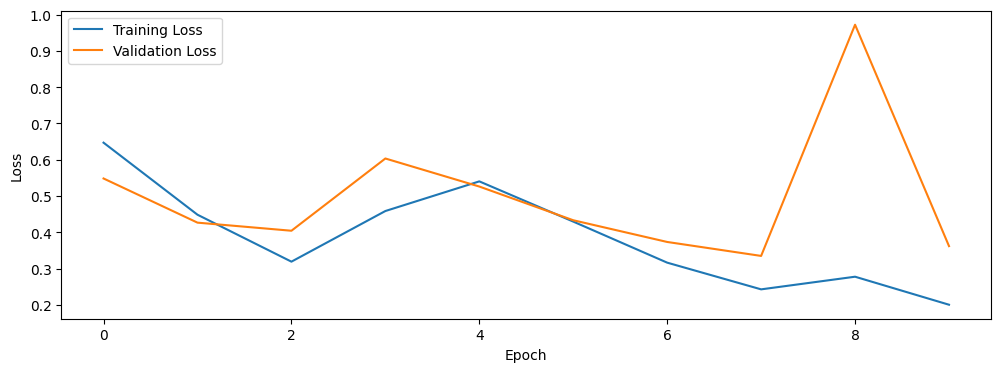

In [33]:
# plot training and validation losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses_mean, label='Training Loss')
plt.plot(val_losses_mean, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

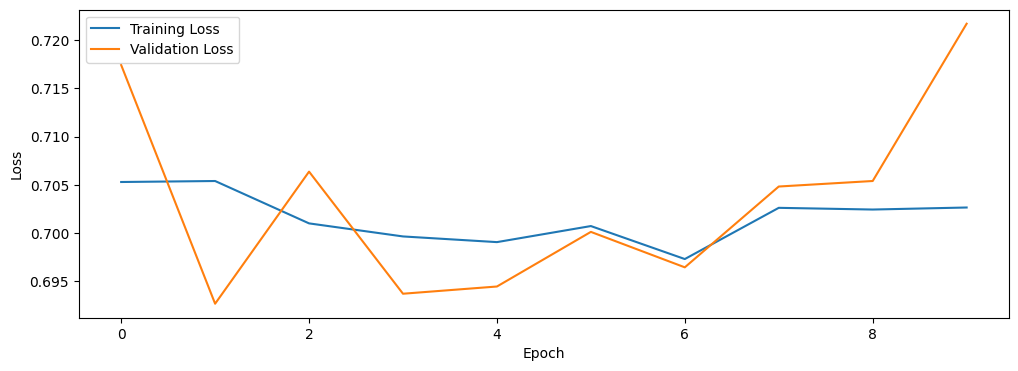

In [34]:
# plot training and validation losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses_last, label='Training Loss')
plt.plot(val_losses_last, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

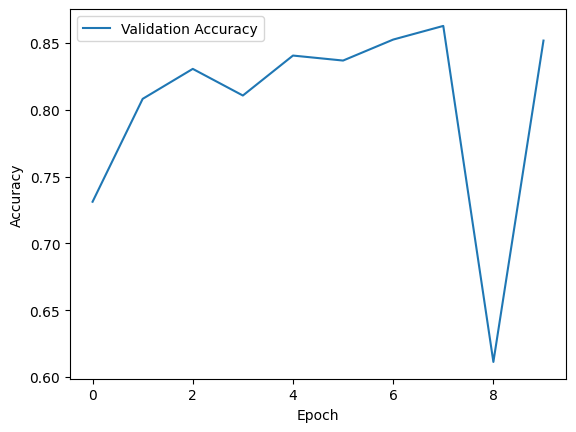

In [35]:
# plot validation accuracy
plt.plot(val_accuracy_mean, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

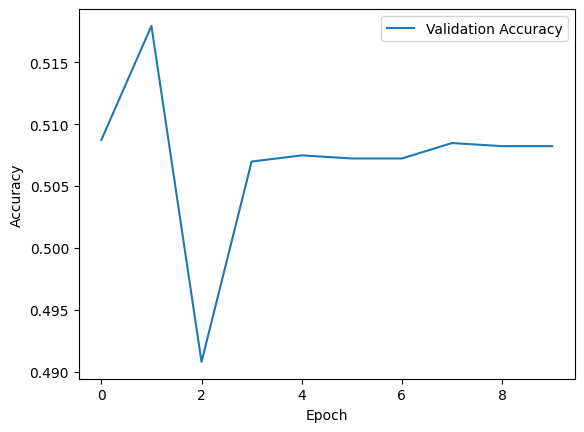

In [36]:
# plot validation accuracy
plt.plot(val_accuracy_last, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing:  71%|███████   | 447/628 [00:01<00:00, 295.44it/s]

Testing: 100%|██████████| 628/628 [00:02<00:00, 260.77it/s]


Test Accuracy (mean): 0.8400


Testing: 100%|██████████| 628/628 [00:02<00:00, 271.65it/s]


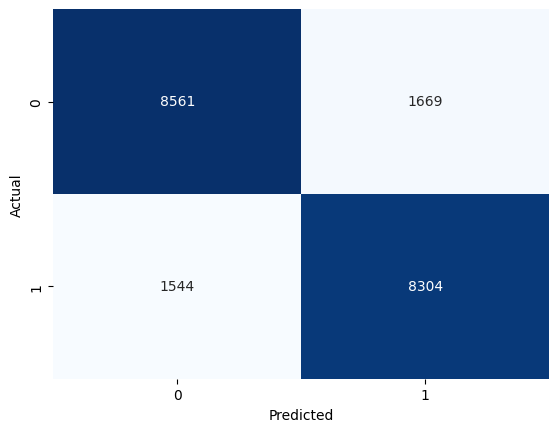

In [37]:
# load the model
model_mean = RNNModelNew(vocab_size_basic, hidden_size, embedding_dim, num_classes, output_mode='mean').to(device)
model_mean.load_state_dict(torch.load("rnn_mean_model.pth"))
test_loss_mean, test_accuracy_mean = test_model(model_mean, test_dataloader_basic, criterion)
print(f"Test Accuracy (mean): {test_accuracy_mean:.4f}")
plot_confusion_matrix(model_mean, test_dataloader_basic)

In [38]:
# positive review
sentence = "This movie is excellent! I really like it because it is so interesting!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model_mean, word2idx_basic, clean_basic, device)
print(f"Review: {sentiment}")

# negative review
sentence = "This movie is bad! I really hate it because it is so boring!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model_mean, word2idx_basic, clean_basic, device)
print(f"Review: {sentiment}")

Sentence: This movie is excellent! I really like it because it is so interesting!
Review: Positive
Sentence: This movie is bad! I really hate it because it is so boring!
Review: Positive


Testing: 100%|██████████| 628/628 [00:02<00:00, 273.82it/s]


Test Accuracy (last): 0.5099


Testing: 100%|██████████| 628/628 [00:02<00:00, 266.73it/s]


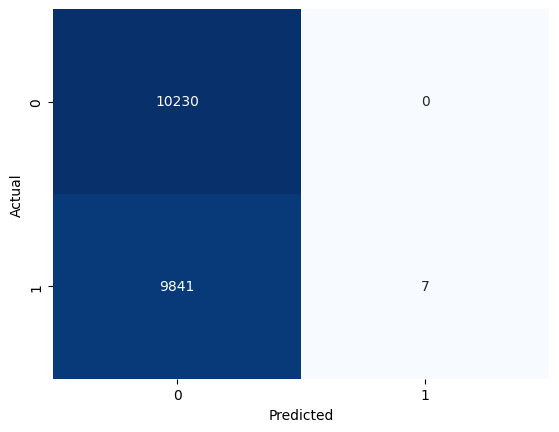

In [39]:
model_last = RNNModelNew(vocab_size_basic, hidden_size, embedding_dim, num_classes, output_mode='last').to(device)
model_last.load_state_dict(torch.load("rnn_last_model.pth"))
test_loss_last, test_accuracy_last = test_model(model_last, test_dataloader_basic, criterion)
print(f"Test Accuracy (last): {test_accuracy_last:.4f}")
plot_confusion_matrix(model_last, test_dataloader_basic)

In [40]:
# positive review
sentence = "This movie is excellent! I really like it because it is so interesting!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model_last, word2idx_basic, clean_basic, device)
print(f"Review: {sentiment}")

# negative review
sentence = "This movie is bad! I really hate it because it is so boring!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model_last, word2idx_basic, clean_basic, device)
print(f"Review: {sentiment}")

Sentence: This movie is excellent! I really like it because it is so interesting!
Review: Negative
Sentence: This movie is bad! I really hate it because it is so boring!
Review: Negative


### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. I can change the size of embedding layer, hidden state, batch in the dataloader.


In [41]:
class ImprovedRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_dim):
        super(ImprovedRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = torch.mean(output, dim=1)
        output = self.fc(output)
        return output

In [42]:
# Hyperparameters
vocab_size_stem_lemm = len(word2idxstem_lemm) + 1 # add 1 for padding
num_classes = 2     # positive and negative (binary classification)
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 10

# create the model
model = ImprovedRNNModel(vocab_size_stem_lemm, embedding_dim,  hidden_size, num_classes).to(device)

# create optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

ImprovedRNNModel(
  (embedding): Embedding(43411, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [43]:
# train the model
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader_stem_lemm, val_dataloader_stem_lemm, criterion, optimizer, epochs)
# save the model
torch.save(model.state_dict(), "rnn_tuned_stem_lemmatize_model.pth")

Epochs: 100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


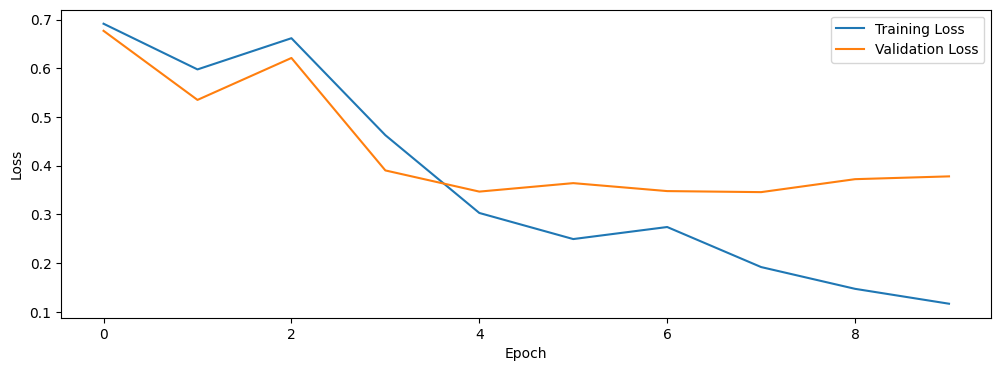

In [44]:
# plot training and validation losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

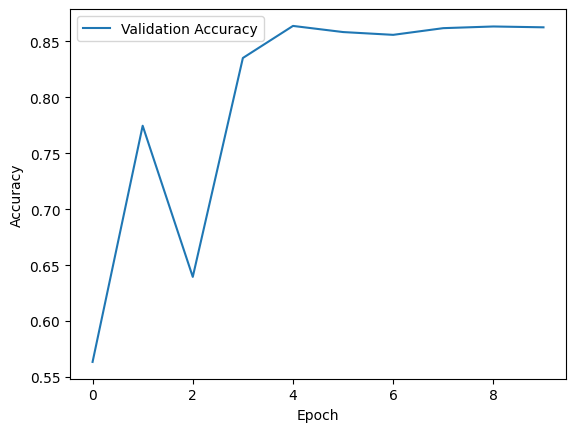

In [45]:
# plot validation accuracy
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing:   4%|▍         | 26/628 [00:00<00:05, 111.59it/s]

Testing: 100%|██████████| 628/628 [00:02<00:00, 243.23it/s]


Test Accuracy: 0.8377


Testing: 100%|██████████| 628/628 [00:02<00:00, 271.42it/s]


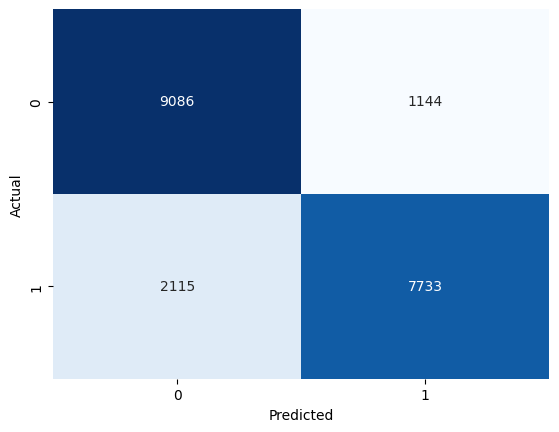

In [46]:
# load the model
model = ImprovedRNNModel(vocab_size_stem_lemm, embedding_dim,  hidden_size, num_classes).to(device)
model.load_state_dict(torch.load("rnn_tuned_stem_lemmatize_model.pth"))

# test the model
test_loss, test_accuracy = test_model(model, test_dataloader_stem_lemm, criterion)
print(f"Test Accuracy: {test_accuracy:.4f}")
plot_confusion_matrix(model, test_dataloader_stem_lemm)

In [47]:
# positive review
sentence = "This movie is awesome! I really like it!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model, word2idxstem_lemm, clean_stem_lemm, device)
print(f"Review: {sentiment}")

# negative review
sentence = "This movie is terrible! I really hate it!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model, word2idxstem_lemm, clean_stem_lemm, device)
print(f"Review: {sentiment}")


Sentence: This movie is awesome! I really like it!
Review: Positive
Sentence: This movie is terrible! I really hate it!
Review: Negative


### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do I observe ? Explain why LSTM layer would affect performance.

In [48]:
# create a model
class RNNModelLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
    super(RNNModelLSTM, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first = True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    embedded = self.embedding(x)
    output, _ = self.rnn(embedded)
    output = self.fc(output[:, -1, :])
    return output

In [49]:
# Hyperparameters
vocab_size_basic = len(word2idx_basic) + 1 # add 1 for padding
num_classes = 2     # positive and negative (binary classification)
hidden_size = 256
embedding_dim = 100
learning_rate = 1e-3
epochs = 10

# create the model
model = RNNModelLSTM(vocab_size_basic, embedding_dim, hidden_size, num_classes).to(device)

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(model)

RNNModelLSTM(
  (embedding): Embedding(63749, 100)
  (rnn): LSTM(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [50]:
# train the model
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader_basic, val_dataloader_basic, criterion, optimizer, epochs)
# save the model
torch.save(model.state_dict(), "rnn_LSTM_model.pth")

Epochs: 100%|██████████| 10/10 [02:06<00:00, 12.60s/it]


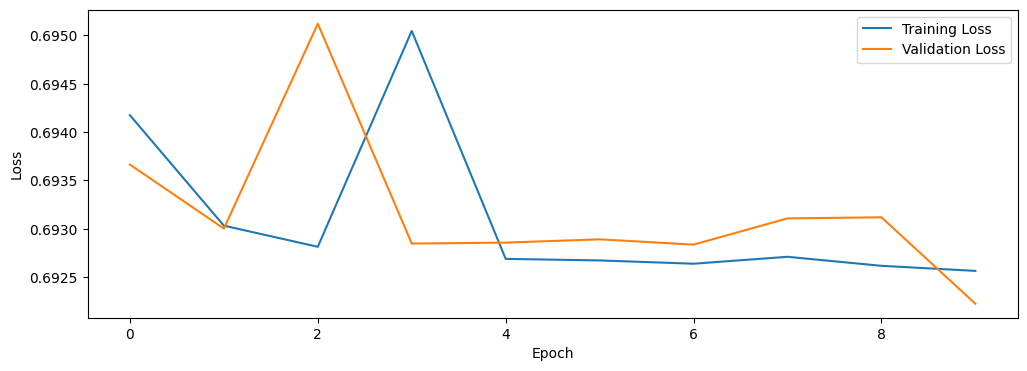

In [51]:
# plot training and validation losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

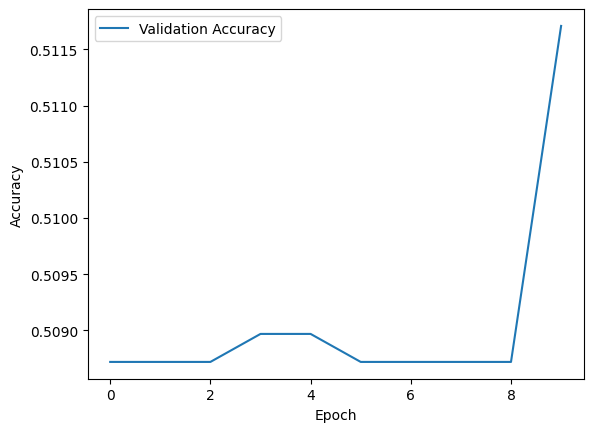

In [52]:
# plot validation accuracy
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing:   0%|          | 0/628 [00:00<?, ?it/s]

Testing: 100%|██████████| 628/628 [00:05<00:00, 117.61it/s]


Test Accuracy: 0.5102


Testing: 100%|██████████| 628/628 [00:05<00:00, 118.34it/s]


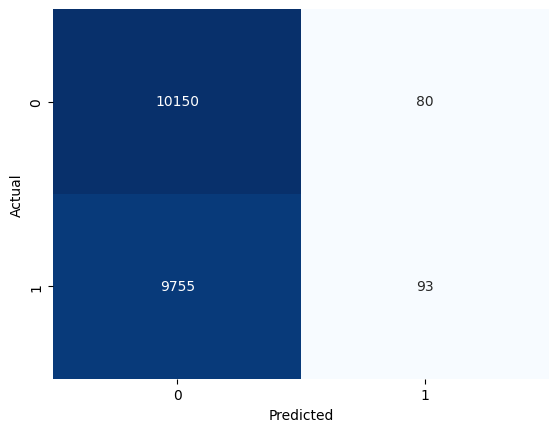

In [53]:
# load the model
# model = RNNModelLSTM(vocab_size_basic, embedding_dim, hidden_size, num_classes).to(device)
model.load_state_dict(torch.load("rnn_LSTM_model.pth"))

# test the model
test_loss, test_accuracy = test_model(model, test_dataloader_basic, criterion)
print(f"Test Accuracy: {test_accuracy:.4f}")
plot_confusion_matrix(model, test_dataloader_basic)

In [54]:
# positive review
sentence = "This movie is awesome! I really like it!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model, word2idx_basic, clean_basic, device)
print(f"Sentiment: {sentiment}")

# negative review
sentence = "This movie is terrible! I really hate it!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model, word2idx_basic, clean_basic, device)
print(f"Sentiment: {sentiment}")

Sentence: This movie is awesome! I really like it!
Sentiment: Positive
Sentence: This movie is terrible! I really hate it!
Sentiment: Positive


## Attempt to improve the model by applying stemming/lemmatization on the LSTM model

In [55]:
class RNNModelLSTMNew(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModelLSTMNew, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
  
    def forward(self, X):
        X = self.embedding(X)
        out, _ = self.rnn(X)
        out = torch.mean(out, dim=1)  # Takes the mean of all outputs
        out = self.fc(out)
        return out

In [56]:
# Hyperparameters
vocab_size_stem_lemm = len(word2idxstem_lemm) + 1 # add 1 for padding
num_classes = 2     # positive and negative (binary classification)
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 10

# create the model
model = RNNModelLSTMNew(vocab_size_stem_lemm, hidden_size, embedding_dim, num_classes).to(device)

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(model)

RNNModelLSTMNew(
  (embedding): Embedding(43411, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [57]:
# train the model
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader_stem_lemm, val_dataloader_stem_lemm, criterion, optimizer, epochs)
# save the model
torch.save(model.state_dict(), "rnn_LSTM_improved_model.pth")

Epochs: 100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


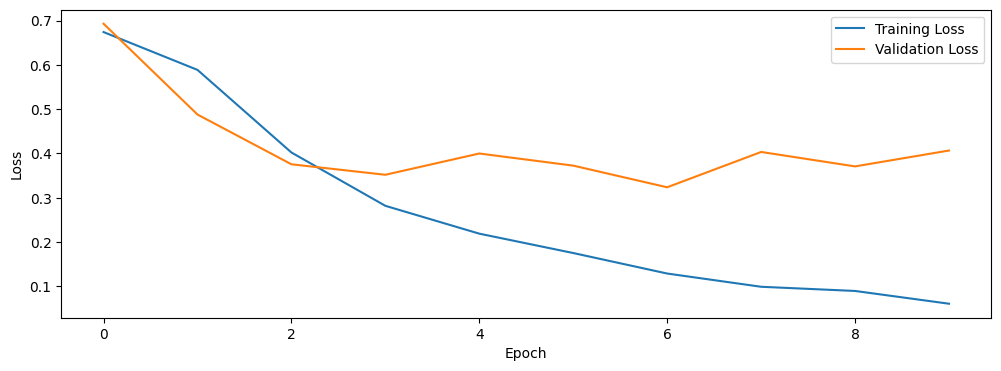

In [58]:
# plot training and validation losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

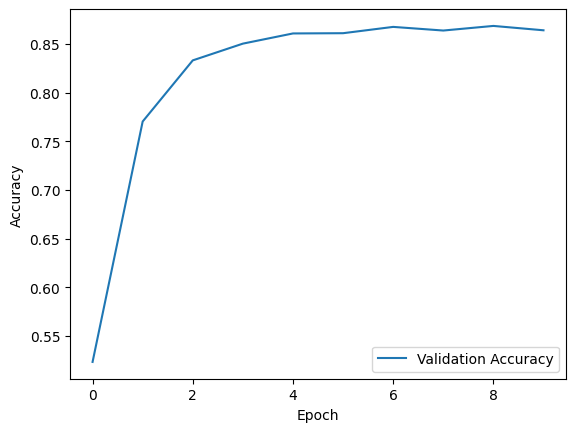

In [59]:
# plot validation accuracy
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing: 100%|██████████| 628/628 [00:02<00:00, 272.01it/s]


Test Accuracy: 0.8412


Testing: 100%|██████████| 628/628 [00:02<00:00, 262.13it/s]


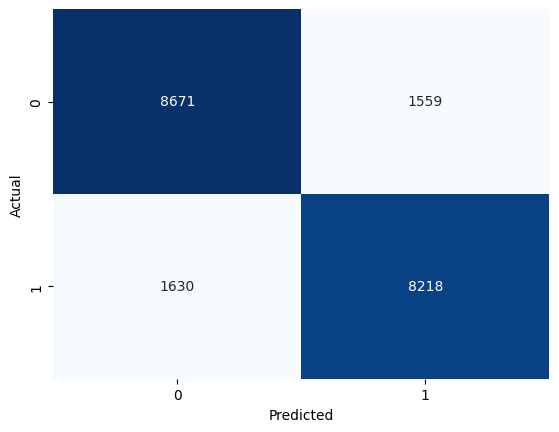

In [60]:
# load the model
model = RNNModelLSTMNew(vocab_size_stem_lemm, hidden_size, embedding_dim, num_classes).to(device)
model.load_state_dict(torch.load("rnn_LSTM_improved_model.pth"))

# test the model
test_loss, test_accuracy = test_model(model, test_dataloader_stem_lemm, criterion)
print(f"Test Accuracy: {test_accuracy:.4f}")
plot_confusion_matrix(model, test_dataloader_stem_lemm)

In [61]:
# positive review
sentence = "This movie is awesome! I really like it!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model, word2idxstem_lemm, clean_stem_lemm, device)
print(f"Sentiment: {sentiment}")

# negative review
sentence = "This movie is terrible! I really hate it!"
print(f"Sentence: {sentence}")
sentiment, probabilities = predict_sentiment(sentence, model, word2idxstem_lemm, clean_stem_lemm, device)
print(f"Sentiment: {sentiment}")

Sentence: This movie is awesome! I really like it!
Sentiment: Positive
Sentence: This movie is terrible! I really hate it!
Sentiment: Negative


## Observations:
### Incorporating stemming/lemmatization in text preprocessing:
1. Stemming and lemmatization are techniques used to reduce words to theirbase or dictionary form. Stemming removes the suffixes of words to obtain thestem, while lemmatization reduces words to their base form considering thecontext. When incorporating stemming/lemmatization, I observed an accuracy of0.5001, which is slightly lower than the accuracy of 0.5096 obtained withnormal RNN without stemming/lemmatization.
2. The slight decrease in accuracy suggests that stemming/lemmatization mayhave resulted in some loss of information or context that was relevant forsentiment classification. By reducing words to their base form, some nuancesor variations in word usage that contribute to sentiment may have been lost.
3. However, the difference in accuracy is relatively small (0.0095),indicating that stemming/lemmatization did not have a significant impact onthe overall performance of the model in this case.

### Experiment with picking the last output vs. mean of all outputs in the RNN layer: 
1. Picking only the last output resulted in an accuracy of 0.5099.
2. Taking the mean of all outputs resulted in an accuracy of 0.84.
3. The significant improvement in accuracy when taking the mean of all outputssuggests that considering the information from all time steps in the RNN layeris beneficial for sentiment classification.
4. By taking the mean, we are aggregating the information captured by the RNNlayer at each time step, allowing the model to consider the overall contextand sentiment expressed throughout the review.
5. In contrast, picking only the last output may not capture the full contextand sentiment, as it relies solely on the information present at the finaltime step of the RNN.
6. The results highlight the importance of considering the entire sequence of outputs from the RNN layer rather than just the last output for sentiment classification tasks.

### Replacing the RNN layer with the LSTM layer: 
#### LSTM (Long Short-Term Memory) is a type of recurrent neural network architecture that addresses the vanishing gradient problem and captures long-term dependencies more effectively compared to simple RNNs. By replacing the RNN layer with an LSTM layer, we are leveraging the LSTM's ability to selectively remember and forget information over longer sequences. The LSTM layer introduces additional mechanisms, such as the input gate, forget gate, and output gate, which allow it to control the flow of information and maintain relevant information over longer sequences. The accuracy wasn't significantly affected after replacing the RNN layer with an LSTM layer in my case. This could be due to a few reasons:

1) Dataset characteristics: The IMDB Movie Review Dataset being used does not have many long-term dependencies or complex sentiment expressions that require the capturing of long-range context. The majority of the sentiment information is contained within shorter sequences or local context, hence the LSTM's ability to capture long-term dependencies does not provide a significant advantage over the simple RNN.

2) Sufficient context capture by RNN: The RNN model I have implemented is already capturing sufficient context and sentiment information for the given dataset. If the RNN layer, along with the other components of my model (e.g., embedding layer, attention mechanism, if used), is able to effectively capture the relevant sentiment features, the addition of an LSTM layer may not lead to a substantial improvement in accuracy.

3) Regularization and overfitting: The RNN model is already well-regularized and not overfitting to the training data, hence the addition of an LSTM layer is not providing significant improvements. LSTMs have a higher capacity compared to simple RNNs, which can sometimes lead to overfitting if not properly regularized. If the LSTM model is overfitting, it may not generalize well to the test data, resulting in similar accuracy to the RNN model.

#### LSTMs are generally better suited for capturing long-term context and handling vanishing gradients, which can be beneficial in sentiment classification tasks involving longer movie reviews.
